# Classifying max vs regular custody level

## Reclassification

**Notebook Setup**

In [1]:
#!pip install bioinfokit

In [2]:
import sys
sys.path.append("../src")
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
#from heatmap import heatmap
import statsmodels.formula.api as smf
#import bioinfokit

In [4]:
plt.style.use('ggplot')

In [5]:
from math391.models.logit_models import LogitModelRunner
from math391.preprocessing import preprocess_for_logit
from math391.plotting import roc_plot

In [6]:
%matplotlib inline

from project import rf_models, preprocessing

df = pd.read_csv("../data/re_custody_2017_gsprs.csv", low_memory=False)



# preprocessing
data = preprocessing.preprocess_input_vars_re(df)
data = data[data.ic_custdy_level > 1]
data['high_re_discip_reports'] = np.where(data['re_discip_reports']>2, 1, 0)

data['re_override_up'] = np.where(data['re_ovride_cust_lvl']-data['re_custody_level']>0,1,0)
data['high_re'] = np.where(data['re_custody_level']>4, 1, 0)
print(data.columns)
data = data[
    [
        "gender_female",
        "age_gt_45",
        "age_lt_25",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O",
        "off_1_prs_max",
        "off_1_gs_max",
        #"ic_custdy_level",
        "prior_commits",
        "re_discip_reports",
        "re_escp_hist_1",
        #"re_escp_hist_2",
        #"re_escp_hist_3",
        #"re_escp_hist_4",
        "re_escp_hist_5",
        "mrt_stat_DIV",
        "mrt_stat_SEP",
        "mrt_stat_MAR",
        "mrt_stat_WID",
        "employed",
        #"high_re_discip_reports",
        "high_re"
    ]
]
data = data.dropna()

df_re_all = data

Index(['re_curr_off_cd_1', 're_curr_off_cd_2', 're_curr_off_cd_3',
       're_prev_off_cd_1', 're_prev_off_cd_2', 're_prev_off_cd_3',
       're_escp_hist_1', 're_escp_hist_2', 're_escp_hist_3', 're_escp_hist_4',
       're_escp_hist_5', 're_discip_reports', 're_age_for_class',
       're_instit_violence', 'ic_prior_commits', 'race', 'sex',
       'ethnic_identity', 'citizenship', 'religion', 'legal_zip_code',
       'ic_employ_ind', 'date_of_birth', 're_custody_level', 'ic_custdy_level',
       'control_number', 're_ovride_cust_lvl', 're_de_year', 'off_1_gs_max',
       'off_1_gs_min', 'off_2_gs_max', 'off_2_gs_min', 'off_3_gs_max',
       'off_3_gs_min', 'off_1_prs_max', 'off_1_prs_min', 'off_2_prs_max',
       'off_2_prs_min', 'off_3_prs_max', 'off_3_prs_min', 'marital_status',
       'ic_mrtl_stat_fr_cl', 'affilatns_ind', 'affilatn_code_1',
       'affilatn_code_2', 'affilatn_code_3', 'affilatn_code_4',
       'affilatn_code_5', 'affilatn_code_6', 'affilatn_code_7',
       'affilat

#### Exploratory data analysis

In [7]:
df_re_all['high_re'].value_counts()

0    13809
1      763
Name: high_re, dtype: int64

In [8]:
count_hi = len(df_re_all[df_re_all['high_re']==0])
count_lo = len(df_re_all[df_re_all['high_re']==1])
pct_hi = count_hi/(count_hi+count_lo)
print("percentage of high lev is", pct_hi*100)
pct_lo = count_lo/(count_hi+count_lo)
print("percentage of low lev is", pct_lo*100)

percentage of high lev is 94.7639308262421
percentage of low lev is 5.236069173757891


#### See how quantitative variables vary with custody level

In [9]:
df_re_all.groupby('high_re').mean()['prior_commits']

high_re
0    3.224564
1    3.656619
Name: prior_commits, dtype: float64

In [10]:
df_re_all.groupby('high_re').mean()['off_1_gs_max']

high_re
0    11.893113
1    11.117955
Name: off_1_gs_max, dtype: float64

In [11]:
df_re_all.groupby('high_re').mean()['off_1_prs_max']

high_re
0    2.551307
1    2.515727
Name: off_1_prs_max, dtype: float64

In [12]:
df_re_all.groupby('high_re').mean()['re_discip_reports']

high_re
0    2.060395
1    3.758847
Name: re_discip_reports, dtype: float64

####  See how quantitative variables vary with race_B

In [13]:
df_re_all.groupby('race_B').mean()['re_discip_reports']

race_B
0    2.055176
1    2.233702
Name: re_discip_reports, dtype: float64

In [14]:
df_re_all.groupby('race_B').mean()['off_1_prs_max']

race_B
0    2.428125
1    2.658165
Name: off_1_prs_max, dtype: float64

In [15]:
df_re_all.groupby('race_B').mean()['off_1_gs_max']

race_B
0    11.169304
1    12.464802
Name: off_1_gs_max, dtype: float64

In [16]:
df_re_all.groupby('race_B').mean()['prior_commits']

race_B
0    3.300566
1    3.199349
Name: prior_commits, dtype: float64

#### Visualizations

Text(0, 0.5, 'Count of people')

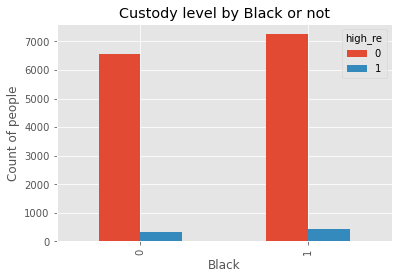

In [17]:
%matplotlib inline
pd.crosstab(df_re_all.race_B,df_re_all.high_re).plot(kind='bar')
plt.title('Custody level by Black or not')
plt.xlabel('Black')
plt.ylabel('Count of people')

Text(0, 0.5, 'Proportion of people')

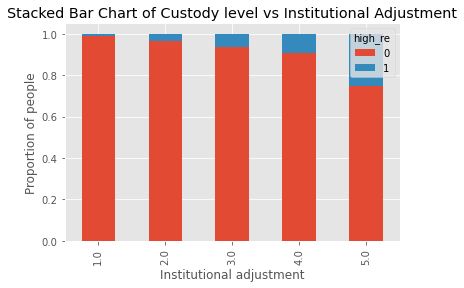

In [18]:
table=pd.crosstab(df_re_all.re_discip_reports,df_re_all.high_re)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Custody level vs Institutional Adjustment')
plt.xlabel('Institutional adjustment')
plt.ylabel('Proportion of people')

Text(0, 0.5, 'Proportion of people')

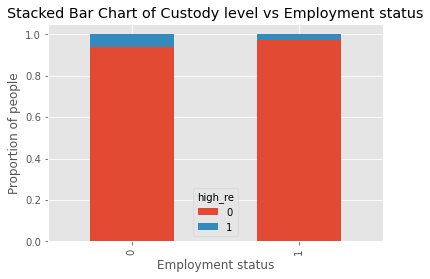

In [19]:
table=pd.crosstab(df_re_all.employed,df_re_all.high_re)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Custody level vs Employment status')
plt.xlabel('Employment status')
plt.ylabel('Proportion of people')

Text(0, 0.5, 'Proportion of people')

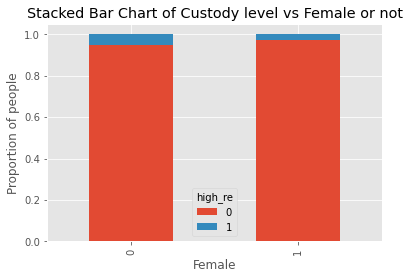

In [20]:
table=pd.crosstab(df_re_all.gender_female,df_re_all.high_re)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Custody level vs Female or not')
plt.xlabel('Female')
plt.ylabel('Proportion of people')

### Building the full model with all features used by the PACT

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [8]:
data_final = df_re_all

In [9]:
#We ommitted escape histories 2, 3 and 4 because they were highly correlated with escape history 1
#and because we want to know if they're frequent escapees or not, and not necessarily how many times


data_final_vars=data_final.columns.values.tolist()
yvars = ['high_re']
Xvars = [i for i in data_final_vars if i not in yvars]
X = data_final.loc[:, data_final.columns != 'high_re']
y = data_final.loc[:, data_final.columns == 'high_re']
ll = ['age_gt_45',
 're_discip_reports',
 're_escp_hist_1',
 're_escp_hist_5',
 'mrt_stat_DIV',
 'mrt_stat_SEP',
 'mrt_stat_MAR',
 'mrt_stat_WID',
 'employed']
ll.append('race_B')
ll.append('race_A')
ll.append('race_H')
ll.append('race_I')
ll.append('race_O')
ll.append('off_1_gs_max')
ll.append('off_1_prs_max')
ll.append('prior_commits')
ll.append('age_lt_25')
ll.append('gender_female')
X = X[ll]


#### Oversampling to get balanced classes

In [10]:
#!pip install imblearn

In [11]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)

In [12]:
from collections import Counter

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

ctr = Counter(y_train['high_re'])

print(ctr)

Counter({0: 9685, 1: 515})


In [13]:
X, y = os.fit_resample(X, y)

In [14]:
ctr = Counter(y['high_re'])

print(ctr)

Counter({0: 13809, 1: 13809})


         Current function value: 0.412475
         Iterations: 35
                             Results: Logit
Model:                  Logit              Pseudo R-squared:   0.405     
Dependent Variable:     high_re            AIC:                22821.4452
Date:                   2021-12-03 22:21   BIC:                22977.7435
No. Observations:       27618              Log-Likelihood:     -11392.   
Df Model:               18                 LL-Null:            -19143.   
Df Residuals:           27599              LLR p-value:        0.0000    
Converged:              0.0000             Scale:              1.0000    
No. Iterations:         35.0000                                          
-------------------------------------------------------------------------
                   Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
-------------------------------------------------------------------------
age_gt_45          -1.8289    0.0654 -27.9725 0.0000    -1.9570   -1.7008
re

/home/ncr006/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Accuracy of logistic regression classifier on test set: 0.81


[[3251  905]
 [ 663 3467]]


              precision    recall  f1-score   support

           0       0.83      0.78      0.81      4156
           1       0.79      0.84      0.82      4130

    accuracy                           0.81      8286
   macro avg       0.81      0.81      0.81      8286
weighted avg       0.81      0.81      0.81      8286



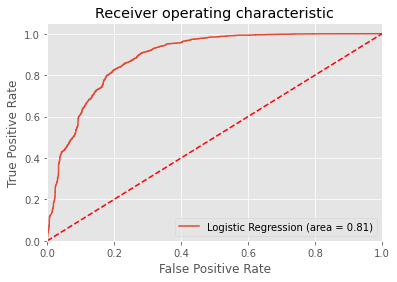

In [29]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

model_odds = pd.DataFrame(np.exp(result.params), columns= ['OR'])
model_odds['z-value']= result.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(result.conf_int())
print(model_odds)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train.values.ravel())
y_pred = logreg.predict(X_test)
print('\nAccuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("\n")
print(cm)
print("\n")
print(classification_report(y_test, y_pred))

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Checking conditions on this model

In [30]:
# Absence of colinearity
Xc = np.asarray(X.corr())
print(Xc.min())
print(Xc[Xc < 1].max())

-0.3436043794440057
0.31186593323782774


#### Continuous IVs linearly related to log odss

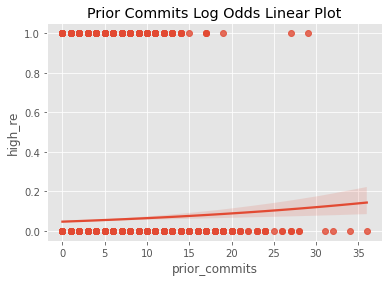

In [31]:
prior_commits = sns.regplot(x= 'prior_commits', y= 'high_re', data=data_final, logistic= True).set_title("Prior Commits Log Odds Linear Plot")

#gre.figure.savefig("gre log lin.png")

#gpa = sns.regplot(x= 'gpa', y= 'admit', data= df, logistic= True).set_title("GPA Log Odds Linear Plot")
#gpa.figure.savefig("gpa log lin.png")

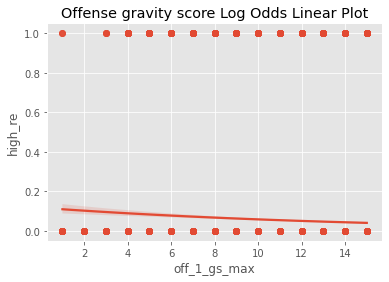

In [32]:
off_1_gs_max = sns.regplot(x= 'off_1_gs_max', y= 'high_re', data=data_final, logistic= True).set_title("Offense gravity score Log Odds Linear Plot")


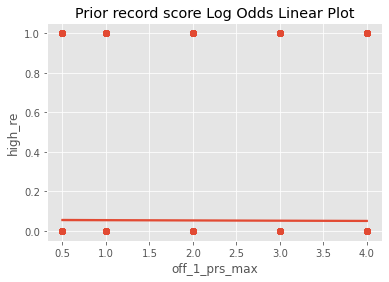

In [33]:
off_1_prs_max = sns.regplot(x= 'off_1_prs_max', y= 'high_re', data=data_final, logistic= True).set_title("Prior record score Log Odds Linear Plot")


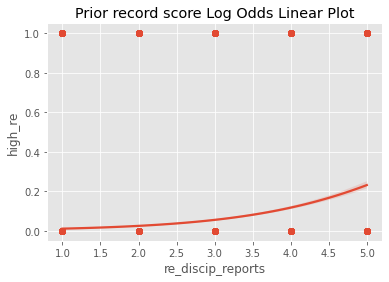

In [34]:
re_discip_reports = sns.regplot(x= 're_discip_reports', y= 'high_re', data=data_final, logistic= True).set_title("Prior record score Log Odds Linear Plot")


#### Outliers

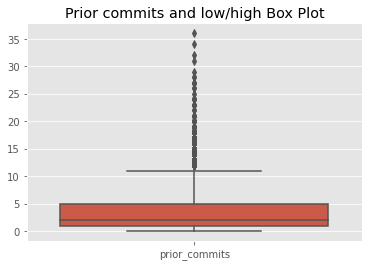

In [35]:
prior_commits_box = sns.boxplot(data= data_final[['prior_commits']]).set_title("Prior commits and low/high Box Plot")


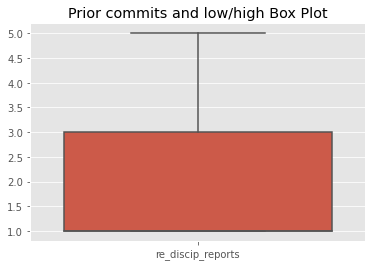

In [36]:
discip_reports_box = sns.boxplot(data= data_final[['re_discip_reports']]).set_title("Prior commits and low/high Box Plot")


/home/ncr006/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ncr006/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


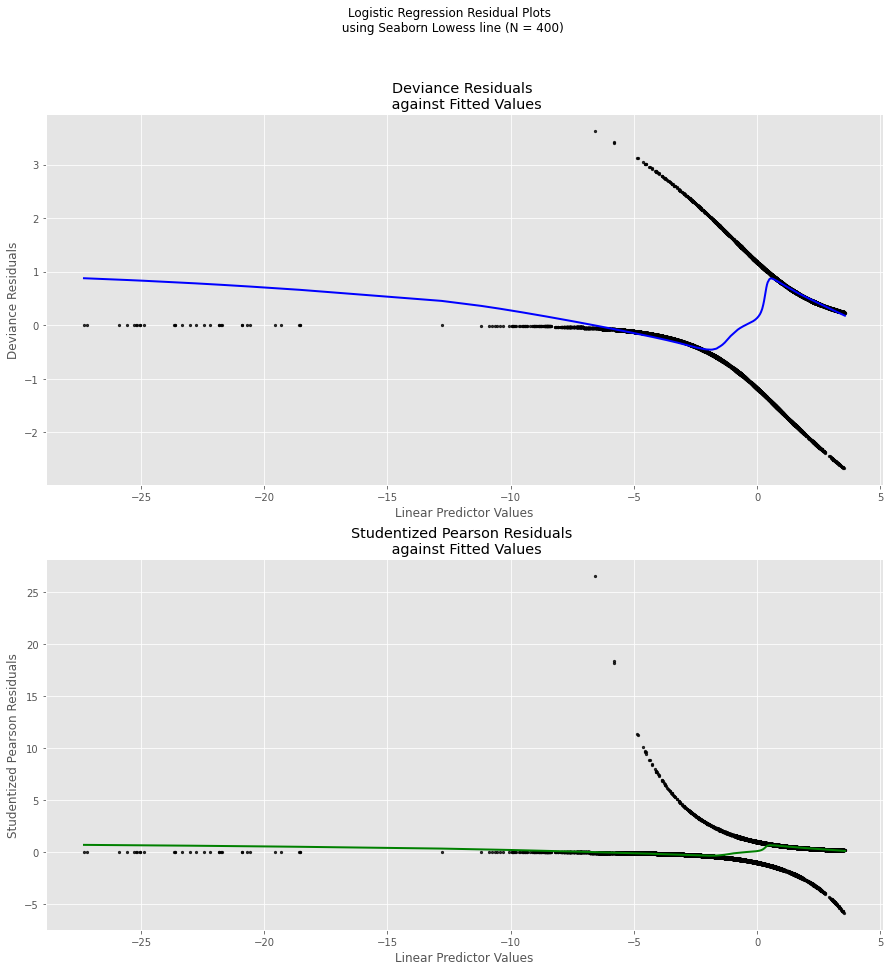

In [37]:
#### Residuals
## Plotting multiple plots same figure
fig, (axL, axR) = plt.subplots(2, figsize=(15, 15))
plt.suptitle("Logistic Regression Residual Plots \n using Seaborn Lowess line (N = 400)")


# Deviance Residuals
sns.regplot(result.fittedvalues, result.resid_dev, ax= axL,
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"b", "alpha":1, "lw":2}, lowess=True)

axL.set_title("Deviance Residuals \n against Fitted Values")
axL.set_xlabel("Linear Predictor Values")
axL.set_ylabel("Deviance Residuals")

# Studentized Pearson Residuals
sns.regplot(result.fittedvalues, result.resid_pearson, ax= axR,
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"g", "alpha":1, "lw":2}, lowess=True)

axR.set_title("Studentized Pearson Residuals \n against Fitted Values")
axR.set_xlabel("Linear Predictor Values")
axR.set_ylabel("Studentized Pearson Residuals")

plt.show()

### Feature selection

In [38]:
ll = ['age_gt_45',
 're_discip_reports',
 're_escp_hist_1',
 're_escp_hist_5',
 'mrt_stat_DIV',
 'mrt_stat_SEP',
 'mrt_stat_MAR',
 'mrt_stat_WID',
 'employed']
ll.append('race_B')
ll.append('race_A')
ll.append('race_H')
ll.append('race_I')
ll.append('race_O')
ll.append('off_1_gs_max')
ll.append('off_1_prs_max')
ll.append('prior_commits')
ll.append('age_lt_25')
ll.append('gender_female')

In [39]:
yvars = ['high_re']
Xvars = [i for i in data_final_vars if i not in yvars]
X = data_final.loc[:, data_final.columns != 'high_re']
y = data_final.loc[:, data_final.columns == 'high_re']

X=X[ll]

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=500) # increase the number of iterations to get convergence
rfe = RFE(logreg, n_features_to_select=4, step=1)
rfe = rfe.fit(X, y.values.ravel())

In [40]:
zz= list(zip(ll,list(rfe.support_)))
features = [a for (a,b) in zz if b]
features

['age_gt_45', 're_discip_reports', 'race_A', 'gender_female']

In [41]:
rfe.support_

array([ True,  True, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
        True])

In [42]:
X.columns.values

array(['age_gt_45', 're_discip_reports', 're_escp_hist_1',
       're_escp_hist_5', 'mrt_stat_DIV', 'mrt_stat_SEP', 'mrt_stat_MAR',
       'mrt_stat_WID', 'employed', 'race_B', 'race_A', 'race_H', 'race_I',
       'race_O', 'off_1_gs_max', 'off_1_prs_max', 'prior_commits',
       'age_lt_25', 'gender_female'], dtype=object)

## SVM

In [19]:
#We ommitted escape histories 2, 3 and 4 because they were highly correlated with escape history 1
#and because we want to know if they're frequent escapees or not, and not necessarily how many times

from sklearn.metrics import accuracy_score





#applying Support Vector Classifier 
#fitting kernel SVM to training dataset
from sklearn.svm import SVC
classifier_df = SVC(kernel = 'linear' , random_state = 0)
classifier_df.fit(X_train,y_train)

#predicting test data result
y_pred = classifier_df.predict(X_test)


#setting up accuracy score

acc = accuracy_score(y_test,y_pred) *100
print("Accuracy for our dataset in predicting test data is : {:.2f}%".format(acc))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy for our dataset in predicting test data is : 94.33%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4124
           1       0.00      0.00      0.00       248

    accuracy                           0.94      4372
   macro avg       0.47      0.50      0.49      4372
weighted avg       0.89      0.94      0.92      4372



/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [16]:
from sklearn.model_selection import GridSearchCV
parameters = [{'C': [1,10,100], 'kernel': ['linear']}]
grid_search = GridSearchCV(estimator= classifier_df,
                          param_grid = parameters, scoring = 'accuracy',cv = 10)
grid_search = grid_search.fit(X_train, y_train)

accuracy = grid_search.best_score_ *100

print("Accuracy for our dataset with tuning is : {:.2f}%".format(accuracy) )

/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy for our dataset with tuning is : 94.95%


## Neural network

In [20]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', 
                    alpha=1e-5,
                    hidden_layer_sizes=(14,), 
                    random_state=1, 
                    max_iter=10000)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test,y_pred) *100
print("Accuracy for our dataset in predicting test data is : {:.2f}%".format(acc))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy for our dataset in predicting test data is : 94.12%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4124
           1       0.20      0.01      0.02       248

    accuracy                           0.94      4372
   macro avg       0.57      0.50      0.50      4372
weighted avg       0.90      0.94      0.92      4372



## Random forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = 0)
clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test,y_pred) *100
print("Accuracy for our dataset in predicting test data is : {:.2f}%".format(acc))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


<ipython-input-21-8bc267bbfbcd>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


Accuracy for our dataset in predicting test data is : 92.89%
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      4124
           1       0.18      0.07      0.10       248

    accuracy                           0.93      4372
   macro avg       0.56      0.53      0.53      4372
weighted avg       0.90      0.93      0.91      4372

